In [4]:
!pip install pyarrow


     --------------------------------------- 21.5/21.5 MB 34.4 MB/s eta 0:00:00


In [71]:
import pandas as pd
import pyarrow.parquet as pq
import numpy as np
from matplotlib import pyplot as plt
import shutil
import copy
import matplotlib

In [7]:
# shutil.copyfile("Dataset", "Dataset_cleaned")
df_taxi = []

# Specify the path to file
# parquet_file = 'Dataset/yellow_tripdata_2020-01.parquet'
lookup_table = 'Dataset/taxi+_zone_lookup.csv'
infected_table = 'Dataset/New_York_State_Statewide_COVID-19_Testing.csv'

# Read the Parquet file into a pandas DataFrame
for month in range (1, 13):
    m = str(month)
    if month < 10:
        m = '0' + m
    dataset_name = "Dataset/yellow_tripdata_2020-" +m+'.parquet'
    df_taxi.append(pd.read_parquet(dataset_name))

# Read the Parquet file into a pandas DataFrame

df_lookup = pd.read_csv(lookup_table)
df_infected = pd.read_csv(infected_table)

# Print the DataFrame to see the data
df_taxi.head()

[         VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0               1  2020-01-01 00:28:15   2020-01-01 00:33:03              1.0   
1               1  2020-01-01 00:35:39   2020-01-01 00:43:04              1.0   
2               1  2020-01-01 00:47:41   2020-01-01 00:53:52              1.0   
3               1  2020-01-01 00:55:23   2020-01-01 01:00:14              1.0   
4               2  2020-01-01 00:01:58   2020-01-01 00:04:16              1.0   
...           ...                  ...                   ...              ...   
6405003         2  2020-01-31 23:08:00   2020-01-31 23:34:00              NaN   
6405004         2  2020-01-31 23:00:00   2020-01-31 23:44:00              NaN   
6405005         2  2020-01-31 23:13:00   2020-01-31 23:38:00              NaN   
6405006         2  2020-01-31 23:02:54   2020-01-31 23:27:10              NaN   
6405007         2  2020-01-31 23:56:37   2020-02-01 00:16:35              NaN   

         trip_distance  Ra

In [29]:
# list of all taxi trip's county
county = []
# iterate through rows and look up the county by matching the PULocationID
def data_cleaning(df, county):
    # indexes of invalid counties
    drop_index = []
    for index, row in df.iterrows():
        # remove unknown locations and EWR
        if df_lookup['Borough'][row["PULocationID"] - 1] == 'Unknown' or df_lookup['Borough'][row["PULocationID"] - 1] == 'EWR':
            drop_index.append(index)
        # remove invalid dates
        elif int(row['tpep_dropoff_datetime'].strftime("%d")) - int(row['tpep_pickup_datetime'].strftime("%d")) > 1:
            drop_index.append(index)
        # lookup the table to find county
        else:
            county.append(df_lookup['Borough'][row["PULocationID"] - 1])
        if index % 100000 == 0:
            print(index)
    # Dropping invalid rows
    return df.drop(df.index[drop_index])

# sum = 0
# for i in range(len(df_taxi)):
#     print(df_taxi[i].shape[0])
#     df_taxi[i] = data_cleaning(df_taxi[i],county)
#     print(county[:10])
#     print(len(county))
#     print(df_taxi[i].shape[0])
#     sum += df_taxi[i].shape[0]
#     print(sum)



6357126
0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
2100000
2200000
2300000
2400000
2500000
2600000
2700000
2800000
2900000
3000000
3100000
3200000
3300000
3400000
3500000
3600000
3700000
3800000
3900000
4000000
4100000
4200000
4300000
4400000
4500000
4600000
4700000
4800000
4900000
5000000
5100000
5200000
5300000
5400000
5500000
5600000
5700000
5800000
5900000
6100000
6200000
6300000
6400000
['Manhattan', 'Manhattan', 'Manhattan', 'Manhattan', 'Queens', 'Queens', 'Queens', 'Queens', 'Queens', 'Manhattan']
6357126
6357126
6357126
6299367
0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
2100000
2200000
2300000
2400000
2500000
2600000
2700000
2800000
2900000
3000000
3100000
3200000
3300000
3400000
3500000
3600000
3700000
3800000
3900000
4000000
4100000
4200000
4300000
4400000
45

In [30]:
# Here is to examine whether the outcome match the data, not necessary
total = 0
print(len(county))
for df in df_taxi:
    total += df.shape[0]
print(total)

24422366
24422366


In [33]:
# small look up table for index of counties
counties = {'Manhattan': 0,'Queens': 1,'Brooklyn': 2,'Bronx': 3,'Staten Island': 4}
# dictionary that record all dates and count
day_case_count = [{} for i in range(5)]
# record of current index in the list, county
position = 0

def count_daily_taxi(df, day_case_count, position):
    for index, row in df.iterrows():

        # if df['tpep_pickup_datetime'][i][:4] == "2021":
        #     break
        # print(index)
        # print(row['tpep_pickup_datetime'].strftime("%m/%d/%Y"))

        # add date if it is not recorded yet
        if row['tpep_dropoff_datetime'].strftime("%m/%d/%Y") not in day_case_count[0]:
            for i in range(5):
                day_case_count[i][row['tpep_dropoff_datetime'].strftime("%m/%d/%Y")] = 0
            day_case_count[counties[county[position]]][row['tpep_dropoff_datetime'].strftime("%m/%d/%Y")] += 1
        # add count if the date exist
        else:
            day_case_count[counties[county[position]]][row['tpep_dropoff_datetime'].strftime("%m/%d/%Y")] += 1
        position += 1

        # if index % 100000 == 0:
        #     print(index)
        #     print(row['tpep_dropoff_datetime'].strftime("%m/%d/%Y"))

    return position

# run the function for all months
for i in range(len(df_taxi)):
    position = count_daily_taxi(df_taxi[i], day_case_count, position)
    # print(day_case_count[0])
    # print(position)

0
01/01/2020
100000
01/01/2020
200000
01/02/2020
300000
01/02/2020
400000
01/03/2020
500000
01/03/2020
600000
01/04/2020
700000
01/05/2020
800000
01/05/2020
900000
01/06/2020
1000000
01/06/2020
1100000
01/07/2020
1200000
01/07/2020
1300000
01/08/2020
1400000
01/08/2020
1500000
01/09/2020
1600000
01/09/2020
1700000
01/10/2020
1800000
01/10/2020
1900000
01/11/2020
2000000
01/11/2020
2100000
01/11/2020
2200000
01/12/2020
2300000
01/13/2020
2400000
01/13/2020
2500000
01/14/2020
2600000
01/14/2020
2700000
01/14/2020
2800000
01/15/2020
2900000
01/15/2020
3000000
01/16/2020
3100000
01/16/2020
3200000
01/17/2020
3300000
01/17/2020
3400000
01/17/2020
3500000
01/18/2020
3600000
01/19/2020
3700000
01/19/2020
3800000
01/20/2020
3900000
01/20/2020
4000000
01/21/2020
4100000
01/21/2020
4200000
01/22/2020
4300000
01/22/2020
4400000
01/23/2020
4500000
01/23/2020
4600000
01/24/2020
4700000
01/24/2020
4800000
01/24/2020
4900000
01/25/2020
5000000
01/25/2020
5100000
01/26/2020
5200000
01/26/2020
5300000


In [35]:
# backup the count
day_case_count_copy = copy.deepcopy(day_case_count)
# print(day_case_count[0])

{'01/01/2020': 148510, '12/18/2019': 0, '12/31/2019': 64, '01/02/2020': 143556, '01/01/2009': 61, '01/03/2020': 165289, '01/02/2021': 5, '01/04/2020': 166097, '01/05/2020': 146046, '01/06/2020': 159615, '01/01/2003': 0, '01/07/2020': 182356, '01/08/2020': 198324, '01/09/2020': 211716, '01/10/2020': 207202, '01/30/2020': 224139, '01/11/2020': 200419, '01/12/2020': 168954, '01/13/2020': 190260, '02/02/2020': 176823, '02/23/2020': 162774, '03/16/2020': 57298, '01/14/2020': 200666, '01/15/2020': 199701, '01/16/2020': 221146, '01/17/2020': 222972, '12/31/2008': 11, '01/18/2020': 176631, '01/19/2020': 160561, '01/20/2020': 143018, '01/21/2020': 193960, '01/22/2020': 204597, '01/23/2020': 214026, '02/12/2020': 219534, '03/04/2020': 211934, '03/25/2020': 10034, '03/26/2020': 9574, '04/16/2020': 7663, '05/07/2020': 10043, '05/28/2020': 11880, '05/29/2020': 13256, '06/19/2020': 19667, '07/10/2020': 21309, '07/31/2020': 30335, '01/24/2020': 214437, '01/25/2020': 209256, '01/26/2020': 171810, '01/

In [39]:
def validate_and_sort(day_case_count):
    key_to_drop = []
    # find invalid dates
    for i in range(len(day_case_count)):
        for key in day_case_count[i].keys():
            if key[6:10] != '2020':
                key_to_drop.append((i, key))
            # if day_case_count[i][key] < 10:
            #     key_to_drop.append((i, key))

    # drop them
    for index, key in key_to_drop:
        for i in range(len(day_case_count)):
            if key in day_case_count[i] and i == index:
                day_case_count[i].pop(key)

    # sort (which is not necessary)
    # for i in range(5):
    #     sorted_dict = dict(sorted(day_case_count[i].items()))

validate_and_sort(day_case_count)

[{'01/01/2020': 148510,
  '01/02/2020': 143556,
  '01/03/2020': 165289,
  '01/04/2020': 166097,
  '01/05/2020': 146046,
  '01/06/2020': 159615,
  '01/07/2020': 182356,
  '01/08/2020': 198324,
  '01/09/2020': 211716,
  '01/10/2020': 207202,
  '01/30/2020': 224139,
  '01/11/2020': 200419,
  '01/12/2020': 168954,
  '01/13/2020': 190260,
  '02/02/2020': 176823,
  '02/23/2020': 162774,
  '03/16/2020': 57298,
  '01/14/2020': 200666,
  '01/15/2020': 199701,
  '01/16/2020': 221146,
  '01/17/2020': 222972,
  '01/18/2020': 176631,
  '01/19/2020': 160561,
  '01/20/2020': 143018,
  '01/21/2020': 193960,
  '01/22/2020': 204597,
  '01/23/2020': 214026,
  '02/12/2020': 219534,
  '03/04/2020': 211934,
  '03/25/2020': 10034,
  '03/26/2020': 9574,
  '04/16/2020': 7663,
  '05/07/2020': 10043,
  '05/28/2020': 11880,
  '05/29/2020': 13256,
  '06/19/2020': 19667,
  '07/10/2020': 21309,
  '07/31/2020': 30335,
  '01/24/2020': 214437,
  '01/25/2020': 209256,
  '01/26/2020': 171810,
  '01/27/2020': 171629,
  '0

In [57]:
def dict_to_lists(day_case_count):
    date = []
    result = []

    # iterate though every date in the year and get it from the dictionary
    # The date and result will be stored in two lists correspondingly for plotting later
    for month in range(1,13):
        month = str(month)
        if int(month) < 10:
            month = '0'+month
        for day in range(1,32):
            day = str(day)
            if int(day) < 10:
                day = '0'+day
            if month+'/'+day+'/2020' in day_case_count:
                date.append(month+'/'+day+'/2020')
                result.append(day_case_count[month+'/'+day+'/2020'])
            # else:
            #     result.append(0)
    return date, result

date_to_result = []
for i in range(len(day_case_count)):
    date_to_result.append(dict_to_lists(day_case_count[i]))
# print(date)
# print(result)

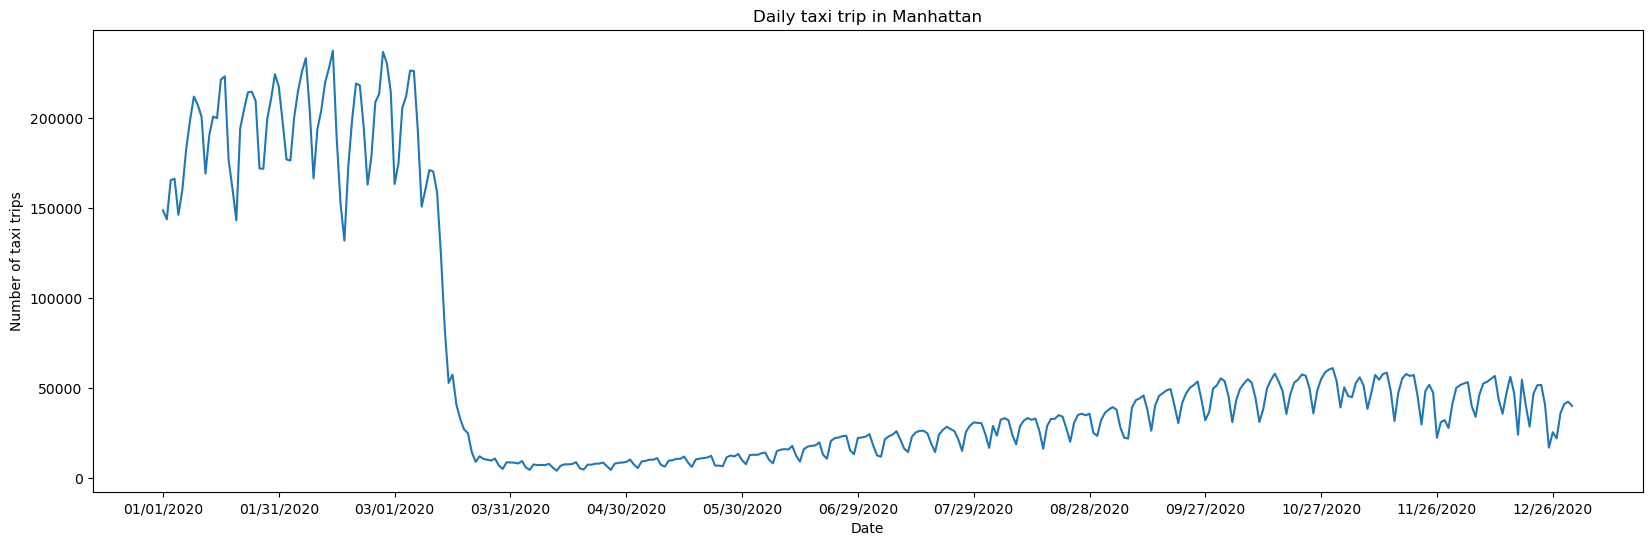

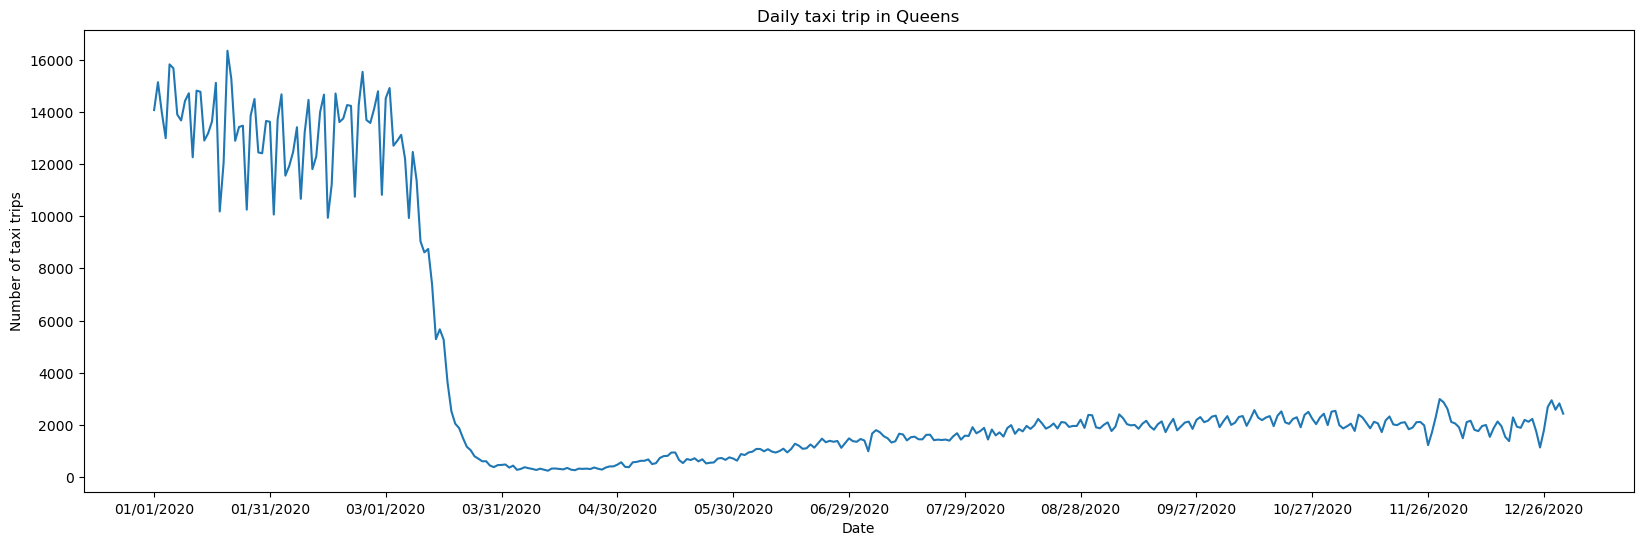

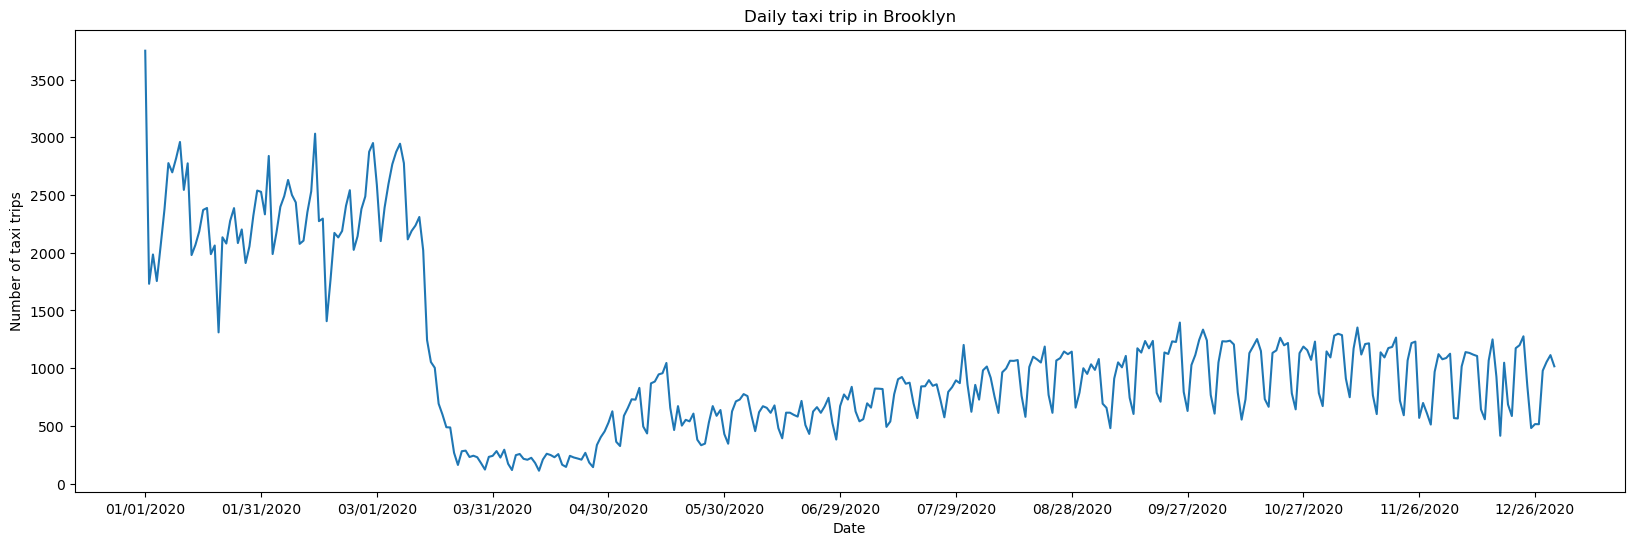

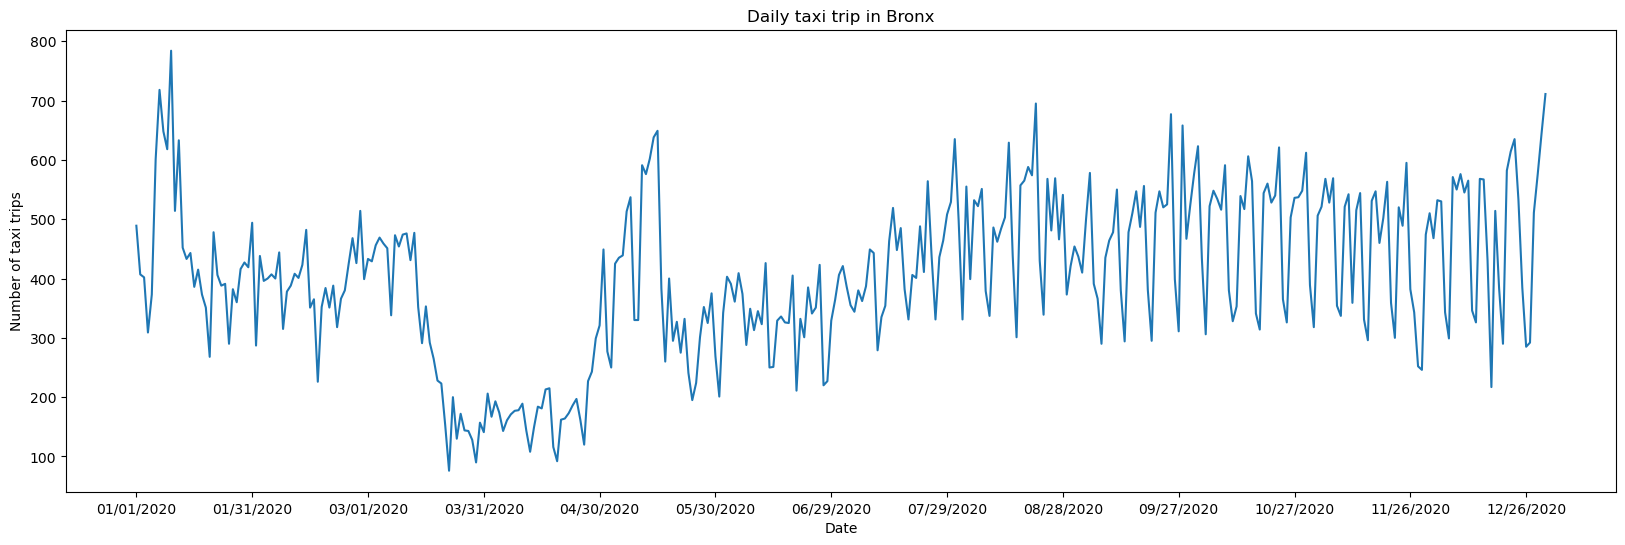

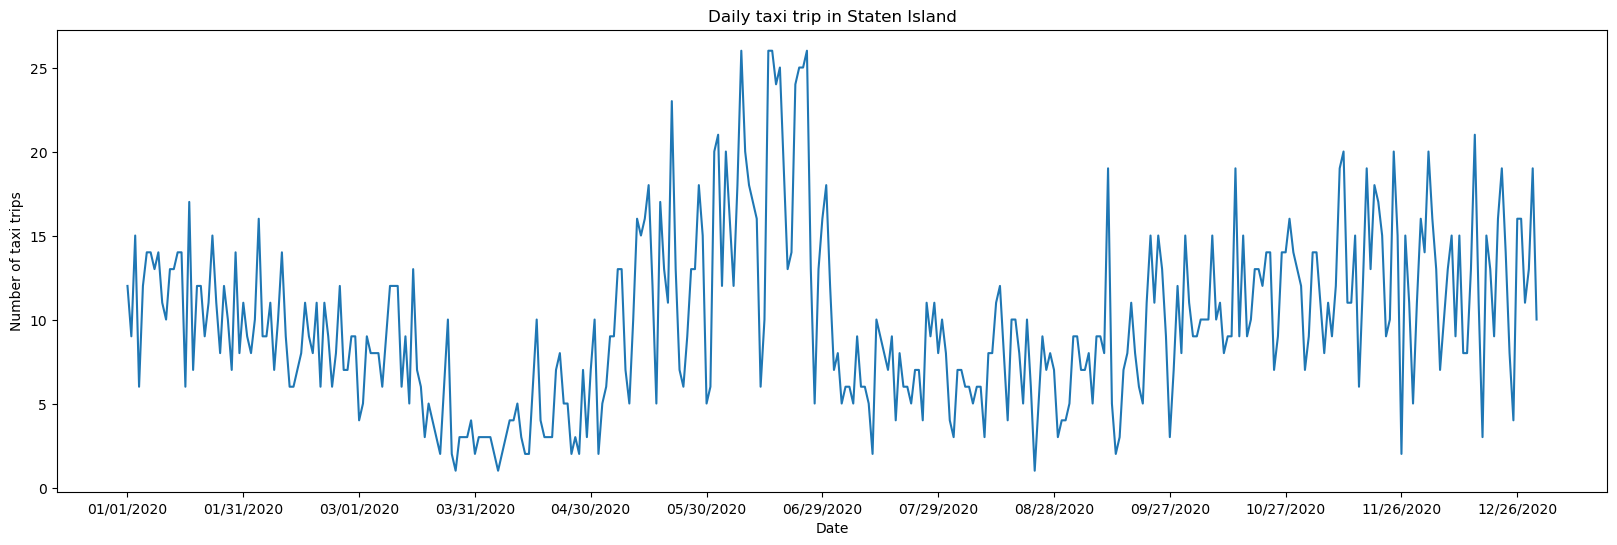

In [64]:
# plot usage versus date for each count (not used, better chart below)
county_range = ["Manhattan", "Queens", "Brooklyn", "Bronx", "Staten Island"]
for i in range(len(date_to_result)):
    plt.figure(figsize=(20,6))
    plt.plot(date_to_result[i][0], date_to_result[i][1])
    plt.xticks(date_to_result[i][0][::30], rotation=0, horizontalalignment="center")
    plt.xlabel("Date")
    plt.ylabel("Number of taxi trips")
    plt.title("Daily taxi trip in "+county_range[i])
    plt.show()

In [79]:
# Read Covid data
df_covid = pd.read_csv("Dataset/New_York_State_Statewide_COVID-19_Testing.csv")

In [80]:
covid_dict = {}
county_dict = {}
county_range = ["Bronx", "New York", "Richmond", "Kings", "Queens"]
# read data to dictionary
for index, row in df_covid.iterrows():
    county = row['County']
    if county in county_range:
        if county not in county_dict:
            county_dict[county] = {'test_dates': [], 'new_positives': []}
        county_dict[county]['test_dates'].append(row['Test Date'])
        county_dict[county]['new_positives'].append(row['New Positives'])

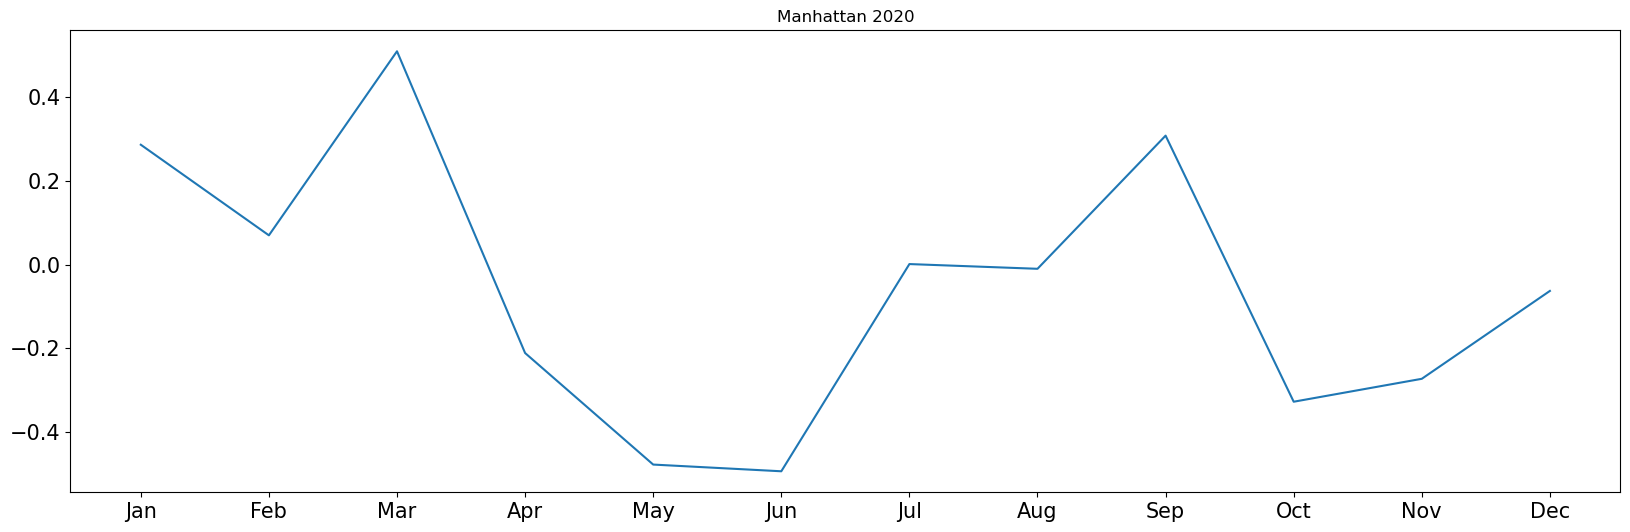

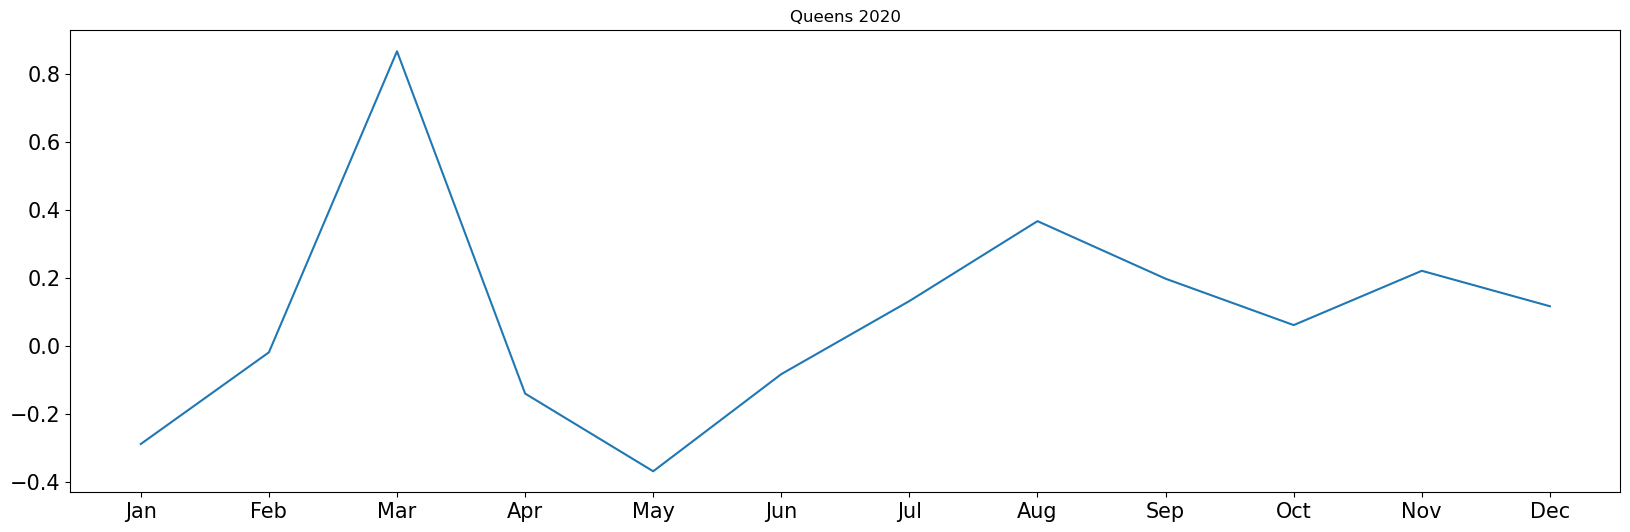

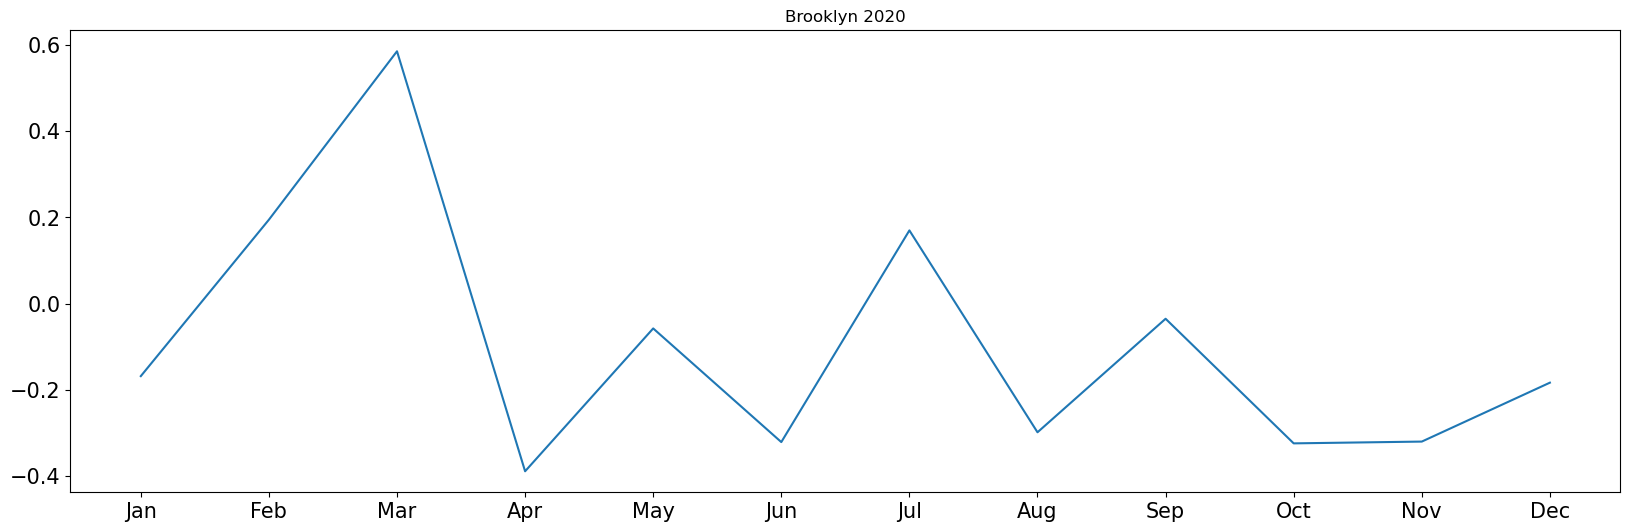

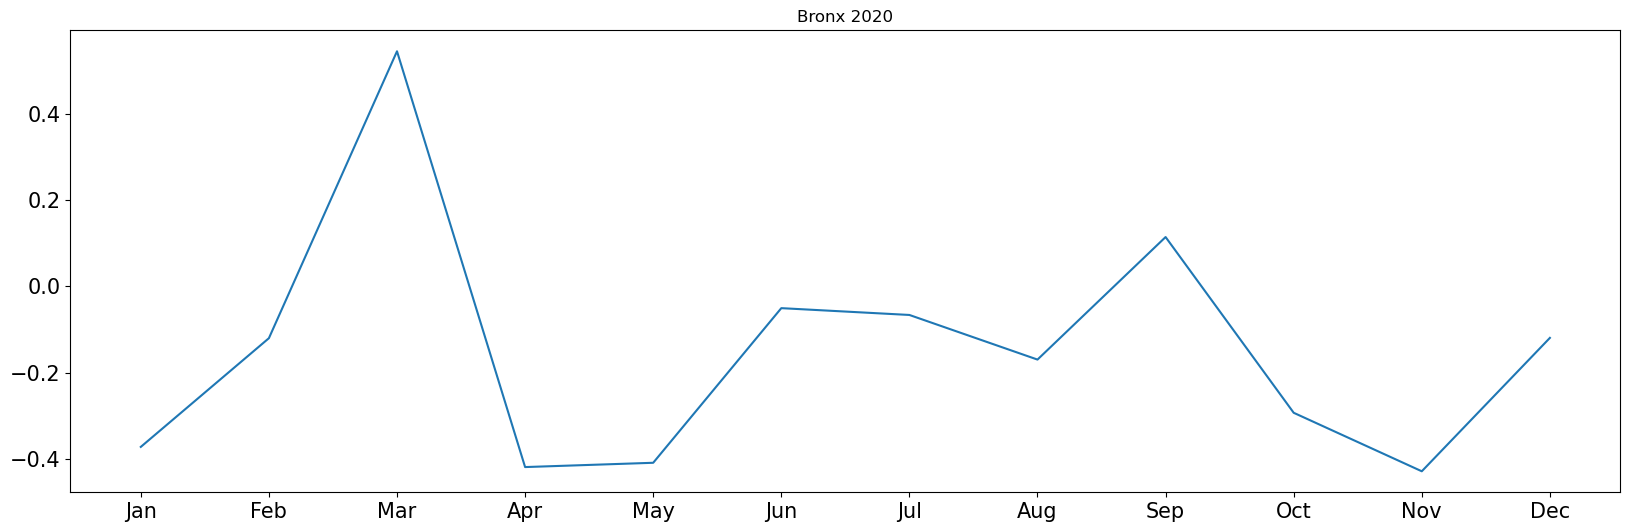

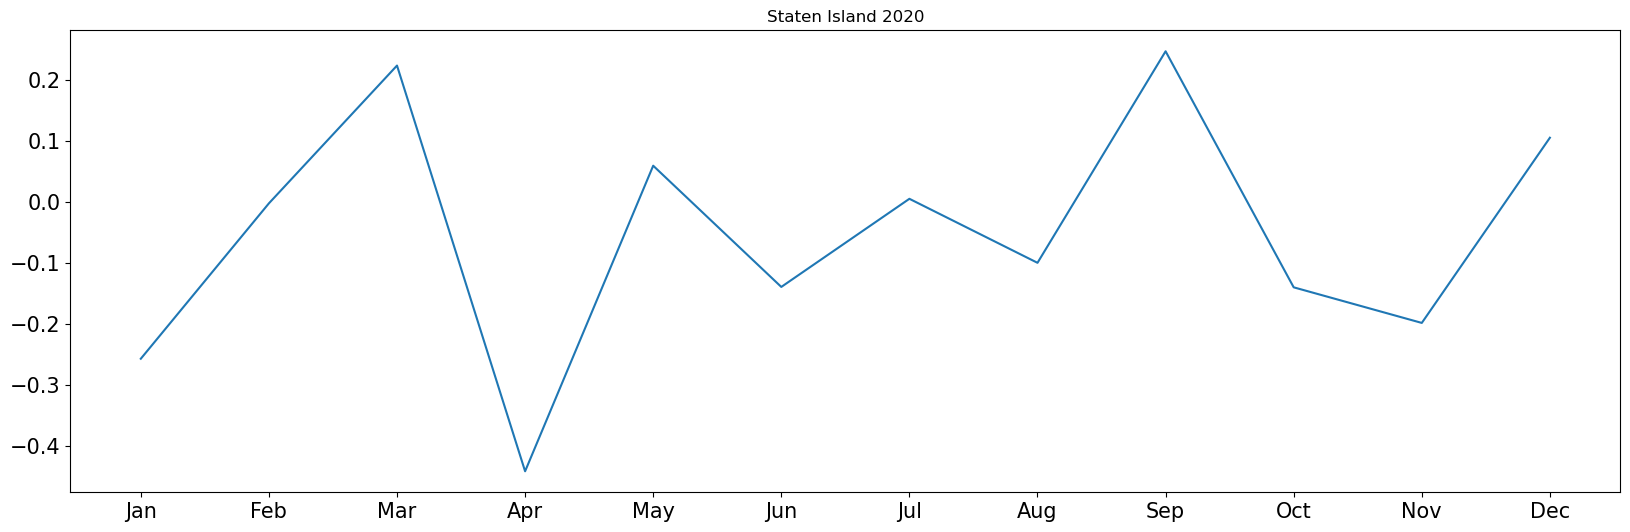

In [116]:
county_range_bike = ["Manhattan", "Queens", "Brooklyn", "Bronx", "Staten Island"]
county_range_covid = ["New York", "Queens", "Kings", "Bronx", "Richmond"]

# get correlation of each month (not important)
for j in range(len(county_range)):
    try:
        # store corresponding county monthly count inside array
        start_dates_covid = list(county_dict[county_range_covid[j]]['test_dates'])
        covid_counts = list(county_dict[county_range_covid[j]]['new_positives'])
        start_dates = date_to_result[j][0]
        taxi_counts = date_to_result[j][1]

        # reverse the data of covid so that it is in chronological order
        start_dates_covid.reverse()
        covid_counts.reverse()

        # start_dates has date format of 2019-08-01
        # start_dates[0][5:7] record the current month
        cur_year = start_dates[0][6:10]
        cur_month = start_dates[0][0:2]
        # print(cur_year,cur_month)
        covid_arr = []
        taxi_arr = []
        col_arr = []

        # start_dates format 2019-08-01
        for i in range(len(start_dates)):
            if start_dates[i][0:2] != cur_month:
                # when encountering a new month, perform action
                # calculate correlation
                col_arr.append(np.corrcoef(covid_arr, taxi_arr)[0,1])
                cur_month = start_dates[i][0:2]
                # empty the list
                covid_arr = []
                taxi_arr = []
            covid_arr.append(covid_counts[i])
            taxi_arr.append(taxi_counts[i])
        # if not a new month, append to the list
        # if a new month, append to the new list
        # [0,1] refers to a specific coefficient we want inside the given correlation matrix
        col_arr.append(np.corrcoef(covid_arr, taxi_arr)[0,1])
        cur_month = start_dates[i][0:2]

        months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
        # monthly_count = np.arange(len(months))
        plt.figure(figsize=(20,6))
        plt.tick_params(axis='x', labelsize=15)
        plt.tick_params(axis='y', labelsize=15)
        plt.title(county_range_bike[j] + " " + cur_year)
        plt.plot(months, col_arr)
        plt.show()
    except KeyError:
        continue

In [121]:
county_range_covid = ["New York", "Queens", "Kings", "Bronx", "Richmond"]
# calculate correlations of each county of 2020
for i in range(5):
    acs_covid_counts_2020 = list(county_dict[county_range_covid[1]]['new_positives'])
    acs_covid_counts_2020.reverse()
    correlation = np.corrcoef(date_to_result[i][1][60:], acs_covid_counts_2020[:306])[0,1]
    print("Correlation in 2020 between Covid and Citibike is:", correlation, " in ", county_range_bike[i])

Correlation in 2020 between Covid and Citibike is: -0.25171293804570277  in  Manhattan
Correlation in 2020 between Covid and Citibike is: -0.2839984912634938  in  Queens
Correlation in 2020 between Covid and Citibike is: -0.4027264193443573  in  Brooklyn
Correlation in 2020 between Covid and Citibike is: -0.3657709820839682  in  Bronx
Correlation in 2020 between Covid and Citibike is: -0.18864784115483416  in  Staten Island


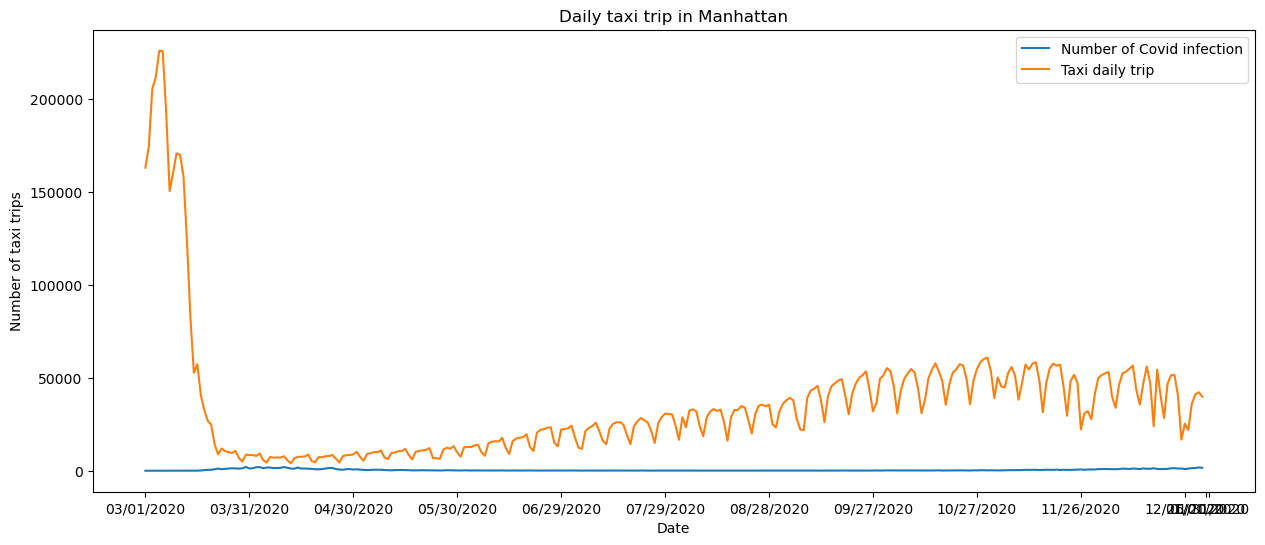

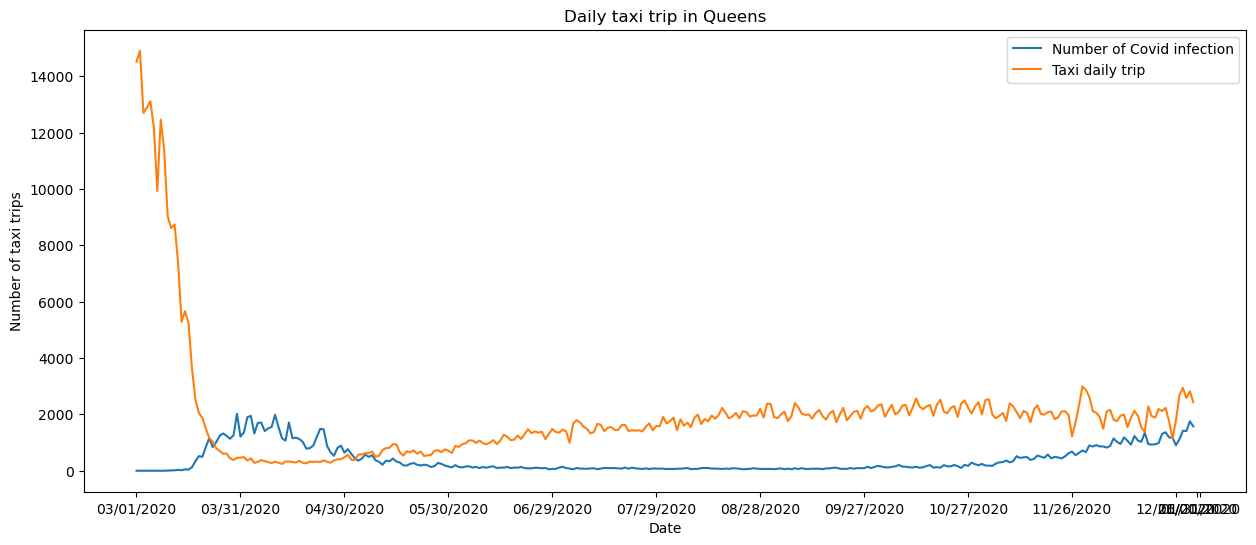

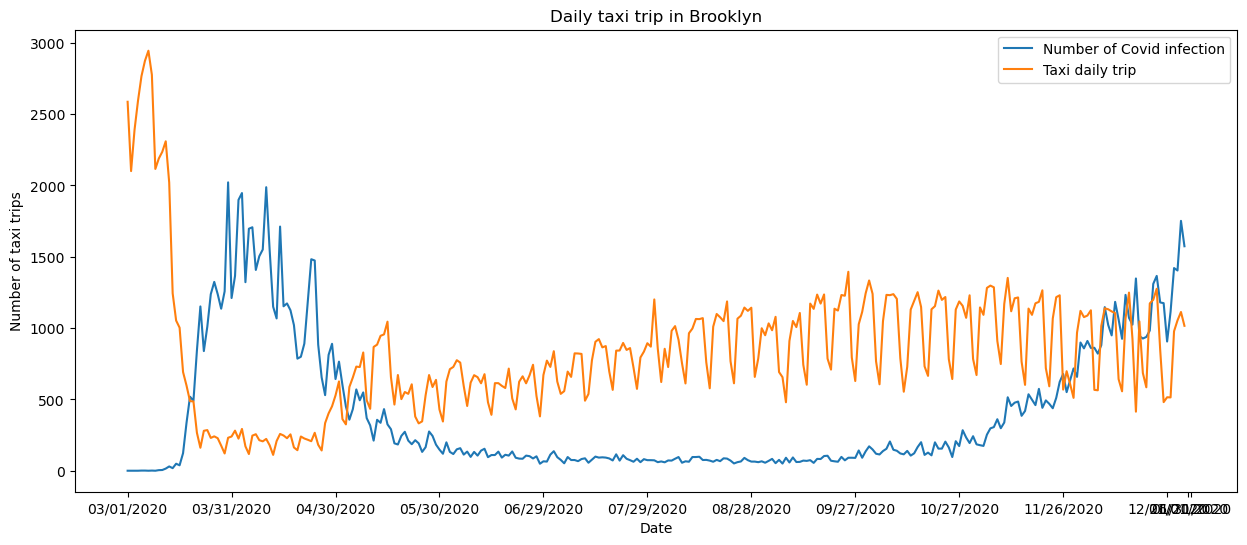

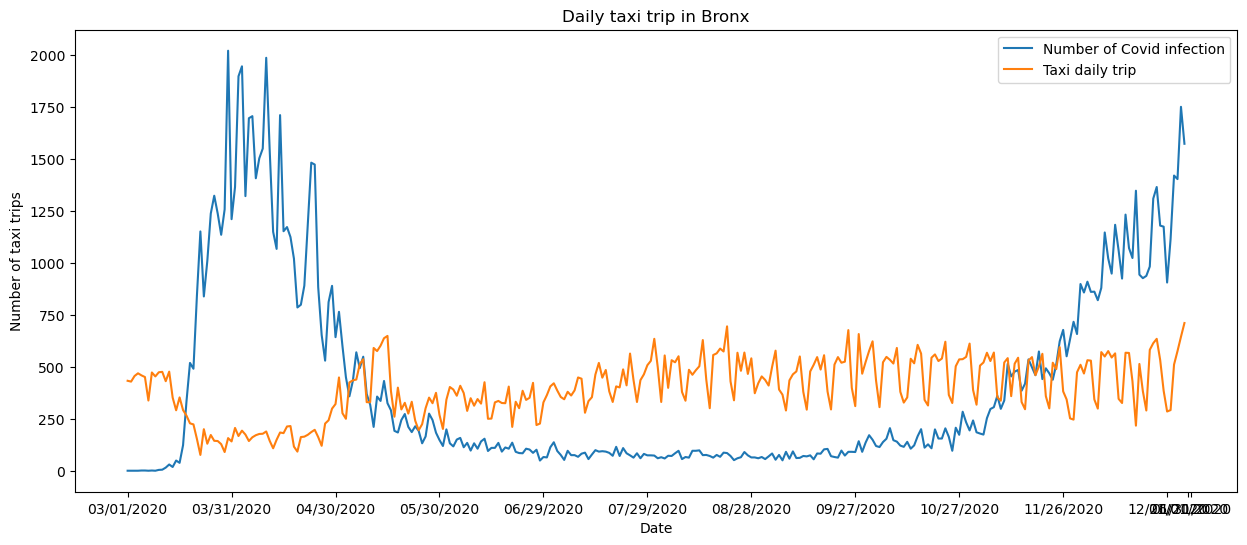

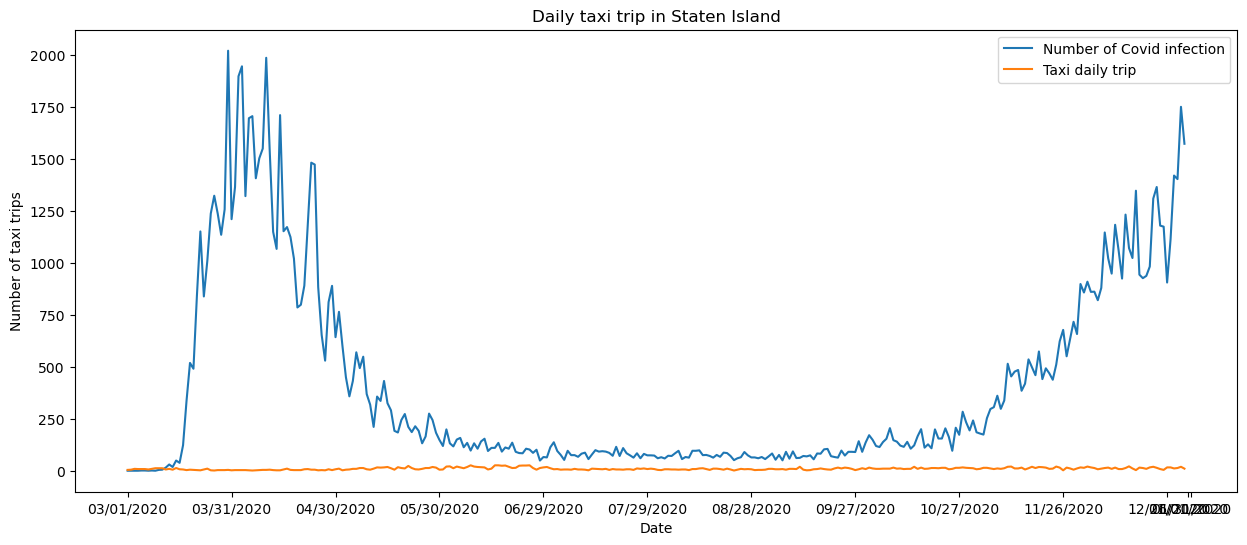

In [130]:
# plot usage versus date and infection versus date on a single chart for each county
county_range = ["Manhattan", "Queens", "Brooklyn", "Bronx", "Staten Island"]
for i in range(len(date_to_result)):
    acs_covid_counts_2020 = list(county_dict[county_range_covid[1]]['new_positives'])
    acs_covid_counts_2020.reverse()
    plt.figure(figsize=(15,6))
    plt.plot(date_to_result[i][0][60:], acs_covid_counts_2020[:306], label = "Number of Covid infection")
    plt.plot(date_to_result[i][0][60:], date_to_result[i][1][60:], label = "Taxi daily trip")
    plt.xticks(date_to_result[i][0][::30], rotation=0, horizontalalignment="center")
    plt.xlabel("Date")
    plt.ylabel("Number of taxi trips")
    plt.title("Daily taxi trip in "+county_range[i])
    plt.legend()
    plt.show()

In [142]:
def calculate_granger_causation_matrix(data, variables, max_lag, test='ssr_chi2test'):
    num_vars = len(variables)
    matrix = pd.DataFrame(np.zeros((num_vars, num_vars)), columns=variables, index=variables)

    for i, causing_var in enumerate(variables):
        for j, caused_var in enumerate(variables):

            test_results = grangercausalitytests(data[[caused_var, causing_var]], max_lag, verbose=False)
            lag_values = [round(test_results[k + 1][0][test][1], 4) for k in range(max_lag)]

            # find the minimum p value
            min_p_value = np.min(lag_values)
            matrix.iloc[j, i] = min_p_value

    matrix.columns = [var + '_cause' for var in variables]
    matrix.index = [var + '_effect' for var in variables]
    return matrix

def find_min_lag(df):
    aic, bic= [], []
    model = VAR(df)
    arr = np.arange(1,50)
    for i in arr:
        result = model.fit(i)
        aic.append(result.aic)
        bic.append(result.bic)
    fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(15,5))

    ax[0].plot(arr, aic, label='AIC',marker='o')
    # plot the second graph
    ax[1].plot(arr, bic, label='BIC',marker='o')
    # ax.set_title("AIC vs BIC")
    ax[0].set_title('AIC')
    ax[1].set_title('BIC')

    return (np.argmin(aic) + 1, np.argmin(bic) + 1)

County: Manhattan
45
              covid_cause  taxi_cause
covid_effect       1.0000         0.0
taxi_effect        0.3414         1.0


County: Queens
10
              covid_cause  taxi_cause
covid_effect       1.0000         0.0
taxi_effect        0.0075         1.0


County: Brooklyn
10
              covid_cause  taxi_cause
covid_effect        1.000         0.0
taxi_effect         0.012         1.0


County: Bronx
8
              covid_cause  taxi_cause
covid_effect       1.0000      0.0041
taxi_effect        0.0002      1.0000


County: Staten Island
7
              covid_cause  taxi_cause
covid_effect       1.0000      0.1714
taxi_effect        0.3658      1.0000




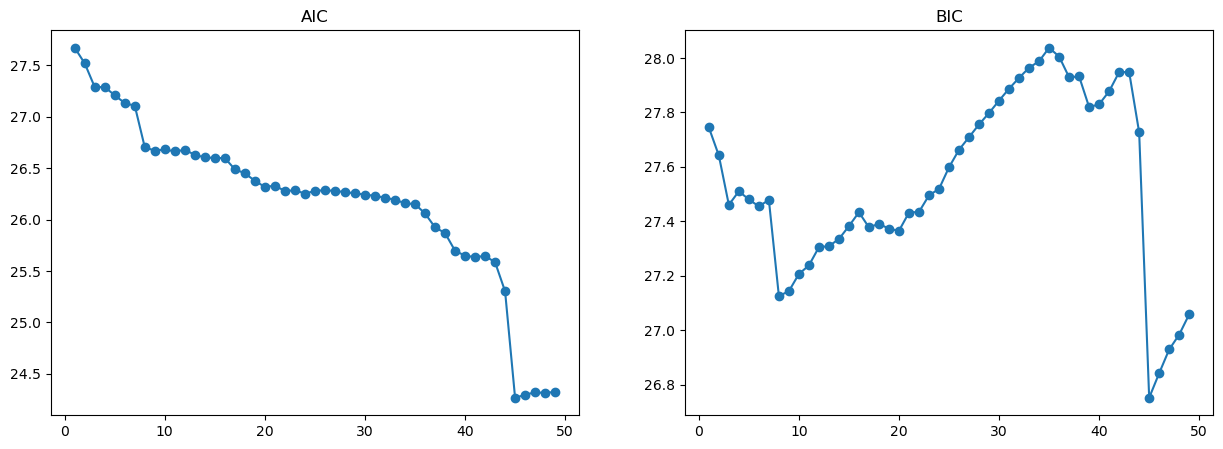

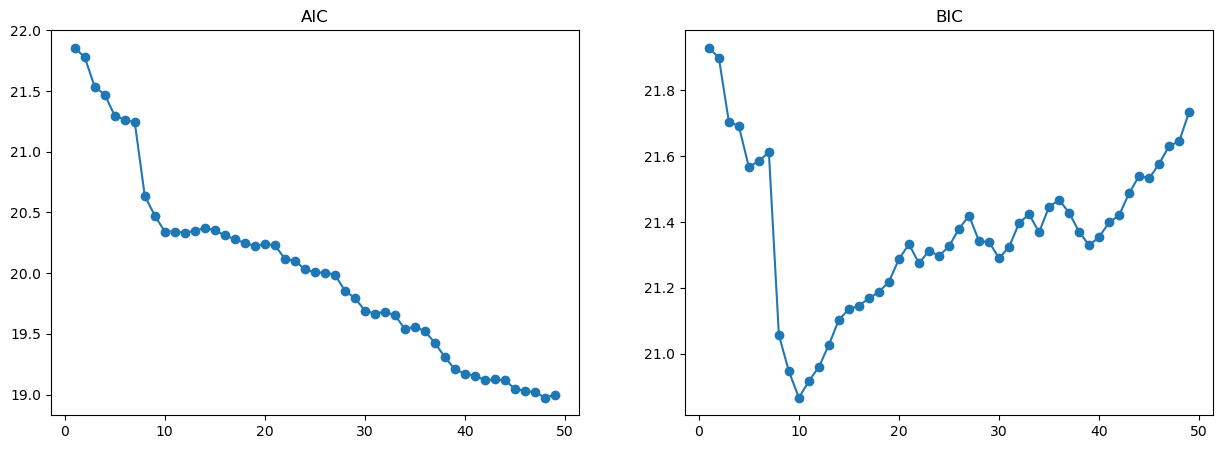

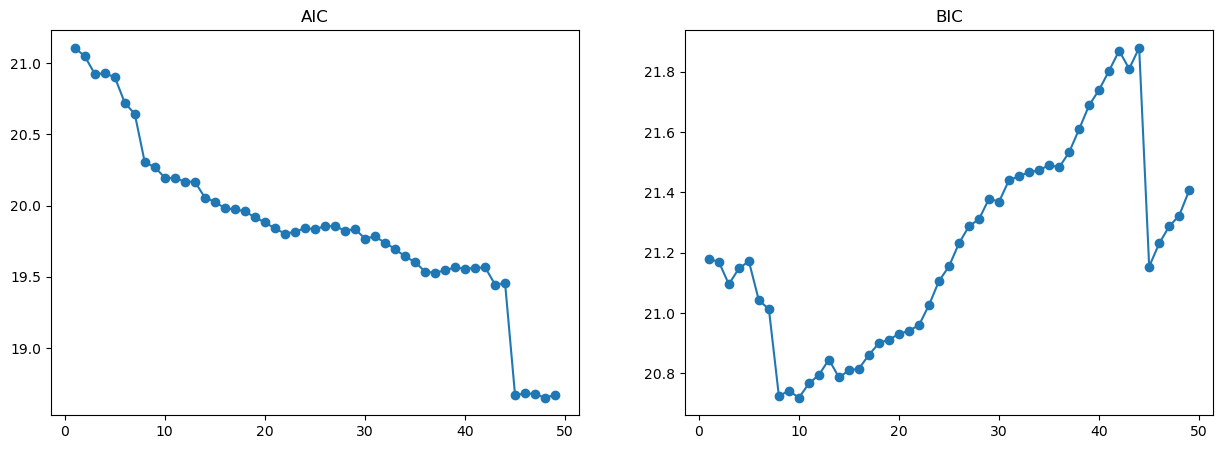

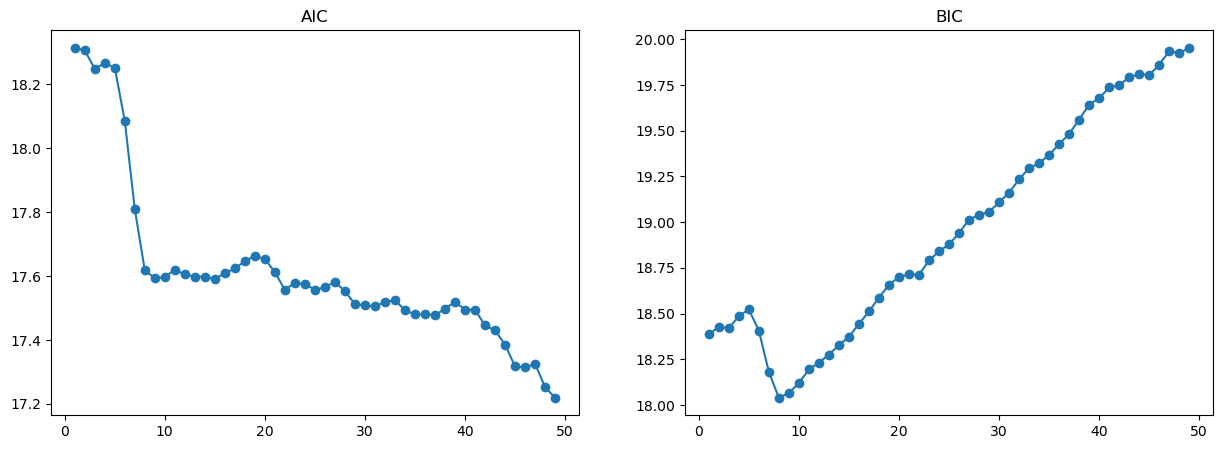

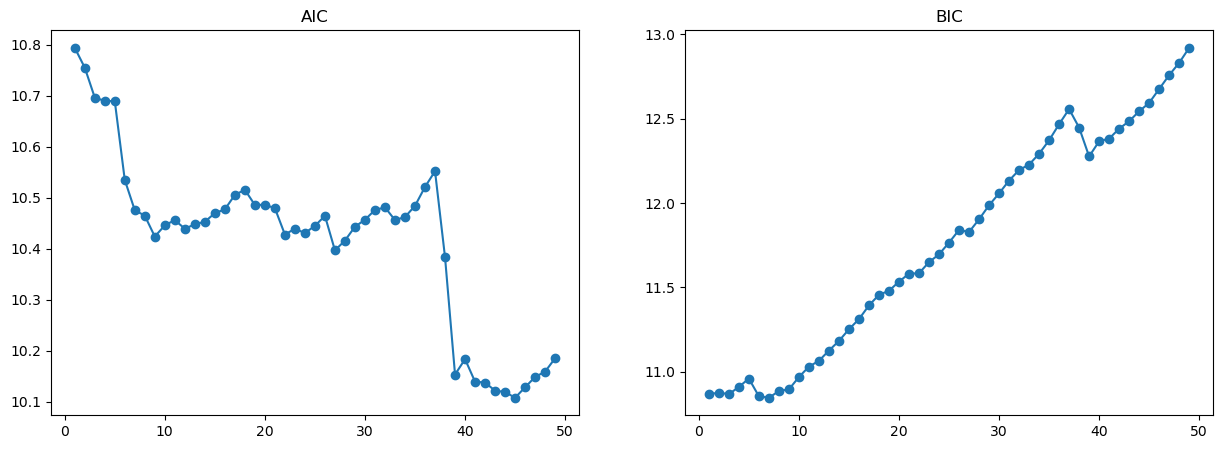

In [143]:
# calculate for granger causality regarding covid and bike
from statsmodels.tsa.stattools import grangercausalitytests
import statsmodels.api as sm
from statsmodels.tsa.vector_ar.var_model import VAR


county_range_bike = ["Manhattan", "Queens", "Brooklyn", "Bronx", "Staten Island"]
county_range_covid = ["New York", "Queens", "Kings", "Bronx", "Richmond"]

for j in range(len(county_range_covid)):
    try:
        # store correspond to county monthly count inside array
        start_dates_covid = list(county_dict[county_range_covid[j]]['test_dates'])
        covid_counts = list(county_dict[county_range_covid[j]]['new_positives'])
        start_dates = date_to_result[j][0]
        taxi_counts = date_to_result[j][1]

        # reverse the data of covid so that it is in chronological order
        start_dates_covid.reverse()
        covid_counts.reverse()

        covid_arr = []
        taxi_arr = []
        col_arr = []

        print("County: " + county_range_bike[j])
        # only for year 2020
        covid_arr = covid_counts[0:366-60]
        taxi_arr = taxi_counts[60:]
        # Convert the data into a DataFrame
        df = pd.DataFrame({'covid': covid_arr, 'taxi': taxi_arr})

        # select p values
        min_p = np.min(find_min_lag(df))
        print(min_p)

        # perform granger analysis

        model = VAR(df)
        var_model = model.fit(min_p)
        print(calculate_granger_causation_matrix(df, df.columns, min_p))
        print("\n")
    except KeyError:
        continue
